# Advanced Lane Finding

The purpose of this code is to calibrate our camera using the 20 chessboard images provided.

A chessboard is used for camera calibration since its regular patterns of high contrast make it easy to detect automatically. So, if we use our camera to take multiple pictures of chessboard agaisnt a flat surface, then we will be able to detect any distortion by looking at the difference between the appartent size and shape of the squares of the chessboard pattern.

We will start by importing all relevant libraries such as opencv, numpy required.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import necessary libraries

Import all necessary libraries. We will be working with OpenCV, Matplotlib, Glob, Pickle, Natsort and NumPy libraries.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import natsort
import pickle

### Display a couple of random test images

Let us display a random image and get its details, such as type, shape, no. of chanels information. We will display one image from daylight and night scenarios.

<Figure size 432x288 with 0 Axes>

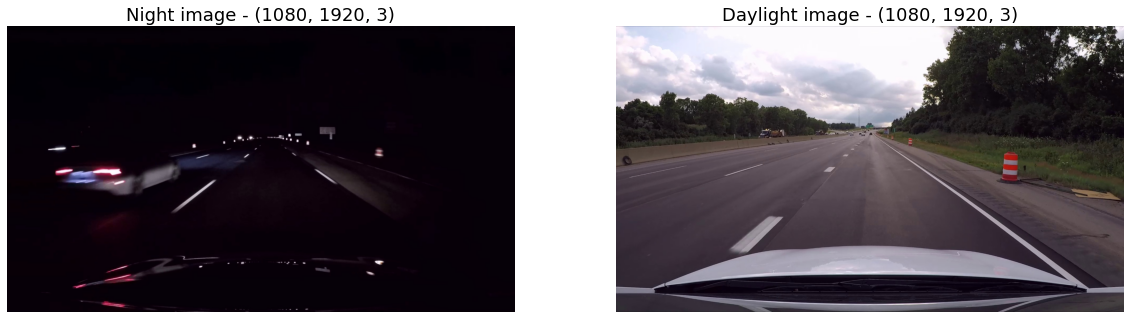

In [2]:
# display a couple of random images

sample_image1 = mpimg.imread("test_images/test1.jpg")
sample_image2 = mpimg.imread("test_images/test7.jpg")

plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_image1)
ax1.set_title(f'Night image - {sample_image2.shape}', fontsize=18)
ax1.axis('off')
ax2.imshow(sample_image2)
ax2.set_title(f'Daylight image - {sample_image2.shape}', fontsize=18)
ax2.axis('off')
plt.show()


## Calibrate Camera Function

There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion.

More information on the use of these functions can be found on the OpenCV documentation website at the following location:

[cv2.calibrateCamera()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera)

[cv2.undistort()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=undistort#cv2.undistort)

Camera calibration for this project is already performed using a set of chessboard corner images in a separate jupyter notebook [camera_calculations.ipynb](./camera_calculations.ipynb)
Here is a sample image -

![image](./readme_images/test_undistortion.jpg)

## Thresholding Functions

In this section, I have written functions for calculating parameters such as Sobel Intensity Gradients, Gradient magnitude, gradient direction, hue, lightness, saturation and applying threshold values to idetify lanelines in images. Each of these functions will extract a binary image with the applied threshold values.

The idea behind writing different functions is that there is little extra effort involved and it is possible to use multiple combinations of these filters to achieve the best result.

In [3]:
# Thresholding functions
# since we have evaludated earlier that HLS gives good image filtering results

# this function returns a bindary image
# this functions accepts a grayscale image as input
def pixel_intensity(img, thresh = (0, 255)):

    # THIS FUNCTION WORKS ONLY ON GRAYSCALE IAMGES!!!
    # 1. apply threshold
    intensity_image = np.zeros_like(img)
    # scaled_pixel = np.uint8(255*img/255)
    # 2. create a binary image
    intensity_image[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return intensity_image


# this function accepts a HLS format image
def lightness_select(img, thresh = (120,255)):
    
    # 2. Apply threshold to lightness channel
    l_channel = img[:,:,1]
    # 3. Create empty array to store the binary output and apply threshold
    lightness_image = np.zeros_like(l_channel)
    lightness_image[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return lightness_image



# this function accepts a HLS format image
def saturation_select(img, thresh = (100,255)):

    # 2. apply threshold to saturation channel
    s_channel = img[:,:,2]
    # 3. create empty array to store the binary output and apply threshold
    sat_image = np.zeros_like(s_channel)
    sat_image[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return sat_image



# this function accepts a RGB format image
# function to create binary image sobel gradients in x and y direction
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 5, thresh = (0,255)):

    # 1. Applying the Sobel depending on x or y direction and getting the absolute value
    if (orient == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if (orient == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 2. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 3. Create mask of '1's where the sobel magnitude is > thresh_min and < thresh_max
    sobel_image = np.zeros_like(scaled_sobel)
    sobel_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_image



# this function accepts a RGB format image
# function to check binary image of sobel magnitude
def mag_sobel(img, sobel_kernel=3, thresh = (0,255)):

    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 2. Magnitude of Sobel
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 3. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 4. Create mask of '1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sobel_mag_image = np.zeros_like(scaled_sobel)
    sobel_mag_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_mag_image



# this function accepts a RGB format image
# function to compute threshold direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 2. Take absolute magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 3. Take Tangent value
    sobel_orient = np.arctan2(abs_sobely, abs_sobelx)
    # 4. Create mask of '1's where the orientation magnitude is > thresh_min and < thresh_max
    dir_image = np.zeros_like(sobel_orient)
    dir_image[(sobel_orient >= thresh[0]) & (sobel_orient <= thresh[1])] = 1
    return dir_image

### Combined Thresholding Function

Using this function, we combine different threshold values together in a binary image. The different images for different thresholdings are saved in separate folders within the folder ***output_images/*** as per the name of the filter.


##### Important:
**Within the combined thresholding function, we call other individual thresholding functions starting from line 13 onwards. The thresholding parameters of all these functions need to be set here.**

We also apply a masking threshold to our image to isolate only the region of interest and remove unneccessary pixel information such as scenery and problematic objects such as vehicle hood.

In [4]:
### Combined Thresholding Function


def combined_threshold(img):

    # convert to hls format and extract channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls = cv2.GaussianBlur(hls,(5,5),cv2.BORDER_DEFAULT)
    s_channel = hls[:,:,2]

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # apply Gaussian Blur with kernel size of 5
    gray_blurred = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
    
    # -------------------------- CALL FUNCTIONS FOR THRESHOLDING HERE! ----------------------------- #

    # get pixel intensity binary image
    # IMPORTANT: THIS FUNCION ACCEPTS GRAYSCALE IMAGES ONLY!!!
    pixel_intensity_binary = pixel_intensity(gray, thresh = (150, 255))
    
    # applying thresholding and storing different filtered images
    l_binary = lightness_select(hls, thresh = (140, 255))
    s_binary = saturation_select(hls, thresh = (100, 255))

    ksize = 7
    gradx = abs_sobel_thresh(gray_blurred, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray_blurred, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    
    # gradx_s_channel = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # assuming lanelines are always at an angle between 30 and 45 degree to horizontal
    dir_binary = dir_threshold(gray_blurred, sobel_kernel=ksize, thresh=(0.55, 0.7))


    # ---------------------------- FUNCTION CALLS FOR THRESHOLDING END ------------------------------ #


    # creating an empty binary image
    combined_l_or_intensity = np.zeros_like(s_binary)
    combined_l_or_intensity[((pixel_intensity_binary == 1) | (l_binary == 1))] = 1

    combined_l_and_intensity = np.zeros_like(s_binary)
    combined_l_and_intensity[((pixel_intensity_binary == 1) & (l_binary == 1))] = 1

    # apply region of interest mask
    height, width = combined_l_or_intensity.shape
    mask = np.zeros_like(combined_l_or_intensity)
    
    # define the region as 
    region = np.array([[0, height-1], [840, 400], [1080, 400], [width-1, height-1]], dtype=np.int32)
    # print(region)
    cv2.fillPoly(mask, [region], 1)

    masked = cv2.bitwise_and(combined_l_or_intensity, mask)
    
    # This section is only for saving the separated hls plots.
    # This is commented out after running it once...

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10))
    ax1.imshow(l_binary, cmap = 'gray')
    ax1.set_title('Lightness', fontsize=18)
    ax1.axis('off')
    ax2.imshow(pixel_intensity_binary, cmap = 'gray')
    ax2.set_title('Pixel Intensity', fontsize=18)
    ax2.axis('off')
    ax3.imshow(combined_l_or_intensity, cmap = 'gray')
    ax3.set_title('Lightness or Intensity', fontsize=18)
    ax3.axis('off')
    ax4.imshow(combined_l_and_intensity, cmap = 'gray')
    ax4.set_title('Lightness and Intensity', fontsize=18)
    ax4.axis('off')
    
    # save hls separation plots
    plt.savefig(('test_images_output/hls_plots/hls-plots-'+ i), cmap = 'gray') 
    
    # save individual images for HSL plots, gradients, magnitude and direction
    mpimg.imsave(('test_images_output/pixel_intensity/intensity-' + i), pixel_intensity_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/gray/gray-' + i), gray, cmap = 'gray')
    mpimg.imsave(('test_images_output/gray/gray-blurred-' + i), gray_blurred, cmap = 'gray')
    
    mpimg.imsave(('test_images_output/l_binary/l_binary-' + i), l_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/s_binary/s_binary-' + i), s_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/gradX_binary/gradx-' + i), gradx, cmap = 'gray')
    mpimg.imsave(('test_images_output/gradY_binary/grady-' + i), grady, cmap = 'gray')
    mpimg.imsave(('test_images_output/dir_binary/direction-' + i), dir_binary, cmap = 'gray')
    # mpimg.imsave(('test_images_output/test_images_gradx_binary/gradx-' + i), gradx, cmap = 'gray')
    
    # saving combined thresholded binary image
    mpimg.imsave(('test_images_output/combined_lightness_or_intensity/combined-'+i),combined_l_or_intensity,cmap='gray')
    mpimg.imsave(('test_images_output/combined_lightness_and_intensity/combined-'+i),combined_l_and_intensity,cmap='gray')

    # end of saving images section, comment out above section after saving the images
    
    return masked

### Perspective Transform

After applying the thresholds, isolating the regions of interest and getting our binary image with identified lanelines, we apply the perspective transform to the image.
We do this using [**cv2.getPerspectiveTransform(src, dst)**](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getperspectivetransform).

This function enables us to obtain a birds-eye view of the lanelines (from top) using which we will calculate lane curvatures.

![image](./readme_images/points_perspective_transform.jpg)

As can be seen in the image above, the following points have been selected to obtain perspective transformed image such that the lanelines appear as parallel.
The pixel locations is selected are (340, 825), (1480, 825), (880, 460) and (1040, 460).

In [5]:
# function for applying perspective view on the images
def perspective_view(img):

    img_size = (img.shape[1], img.shape[0])

    # image points extracted from image approximately
    bottom_left = [340, 825]
    bottom_right = [1480, 825]
    top_left = [880, 460]
    top_right = [1040, 460]

    src = np.float32([bottom_left, bottom_right, top_right, top_left])

    pts = np.array([bottom_left, bottom_right, top_right, top_left], np.int32)
    pts = pts.reshape((-1, 1, 2))
    # create a copy of original img
    imgpts = img.copy()
    cv2.polylines(imgpts, [pts], True, (255, 0, 0), thickness = 3)

    # choose four points in warped image so that the lines should appear as parallel
    bottom_left_dst = [600, 1080]
    bottom_right_dst = [1300, 1080]
    top_left_dst = [600, 1]
    top_right_dst = [1300, 1]

    dst = np.float32([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

    # apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)

    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # warp the image using perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

### Getting images from a directory

Here I have prepared a directory to read images from. The directory contains multiple images which we will use for our thresholding, perspective transform and masking trials. We will also create a directory to save the output images. This directory will contain a separate folder structure for different thresholded images.
Following is a list of folders that will be created for storing binary thresholded images:


| Image Folder Name  | Stored Image details |
| :--- | :--- | 
| [test_images_output/gray](./test_images_output/gray/) | Grayscale Images |
| [test_images_output/gray_blurred](./test_images_output/gray_blurred/) | GrayScale Images with Gaussian Blur Applied |
| [test_images_output/dir_binary](./test_images_output/dir_binary/) | Sobel Gradient Direction |
| [test_images_output/l_binary](./test_images_output/l_binary/) | Lightness channel threshold |
| [test_images_output/s_binary](./test_images_output/s_binary/) | Saturation channel threshold |
| [test_images_output/gradx_binary](./test_images_output/gradx_binary) | Sobel gradient in X direction |
| [test_images_output/grady_binary](./test_images_output/grady_binary) | Sobel gradient in Y direction |
| [test_images_output/pixel_intensity](./test_images_output/pixel_intensity/) | Pixel Intensity |
| [test_images_output/combined_lightness_and_intensity](./test_images_output/combined_lightness_and_intensity/) | Lightness and Pixel Intensity combined|
| [test_images_output/combined_lightness_or_intensity](./test_images_output/combined_lightness_or_intensity/) | Lightness or Pixel Intensity combined |
| [test_images_output/hls_plots](./test_images_output/hls_plots/) | Separated Channel Plots of Intensity, L, and S channels |
| [test_images_output/undistorted](./test_images_output/undistorted/) | Undistorted Images |
| [test_images_output/thresholded_masked](./test_images_output/thresholded_masked/) | Combined Threshold and Region of Interest Applied |
| [test_images_output/binary_warped](./test_images_output/binary_warped) | Thresholded, Undistorted and Warped|

In [6]:
# Let us test our functions on given test images
directory = os.listdir("test_images/")
# sorting the images based on ids
directory = natsort.natsorted(directory)
print(directory)

# define output directory here
output_directory = "test_images_output"

try:
    os.mkdir(output_directory)
except FileExistsError:
    print(f"Folder with name {output_directory} already exists!!!")
    print("New images will be merged with the contents of the existing folder!")
    pass

try:
    # create the rest of the folder structure
    os.mkdir(output_directory + '/binary_warped')
    os.mkdir(output_directory + '/combined_lightness_and_intensity')
    os.mkdir(output_directory + '/combined_lightness_or_intensity')
    os.mkdir(output_directory + '/dir_binary')

    os.mkdir(output_directory + '/gradx_binary')
    os.mkdir(output_directory + '/grady_binary')
    os.mkdir(output_directory + '/gray')
    os.mkdir(output_directory + '/gray_blurred')
    os.mkdir(output_directory + '/hls_plots')

    os.mkdir(output_directory + '/l_binary')
    os.mkdir(output_directory + '/pixel_intensity')
    os.mkdir(output_directory + '/s_binary')
    os.mkdir(output_directory + '/thresholded_masked')
    os.mkdir(output_directory + '/undistorted')
except FileExistsError:
    print("Warning!!! - Some folders already exist! Their contents will be overwritten!")
    pass


['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test8.jpg', 'test9.jpg', 'test10.jpg', 'test11.jpg']


### Load Saved Pickle Data

By printing matrix data from pickle here, we will confirm that undistortion matrices have been saved correctly.

In [7]:
file = open('pickle/dist_pickle.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')

mtx, dst = data.values()

print("Saved distortion matrix coeffiencient:")
print("mtx = ", mtx)
print()
print("dst = ", dst)

Showing the pickled data:
Saved distortion matrix coeffiencient:
mtx =  [[1.11976774e+03 0.00000000e+00 9.64549015e+02]
 [0.00000000e+00 1.11133051e+03 7.25644361e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

dst =  [[-0.26776597  0.11511928 -0.0013741  -0.00063393 -0.02582954]]


### Run functions for Combined Thresholding and Perspective Transform on test images

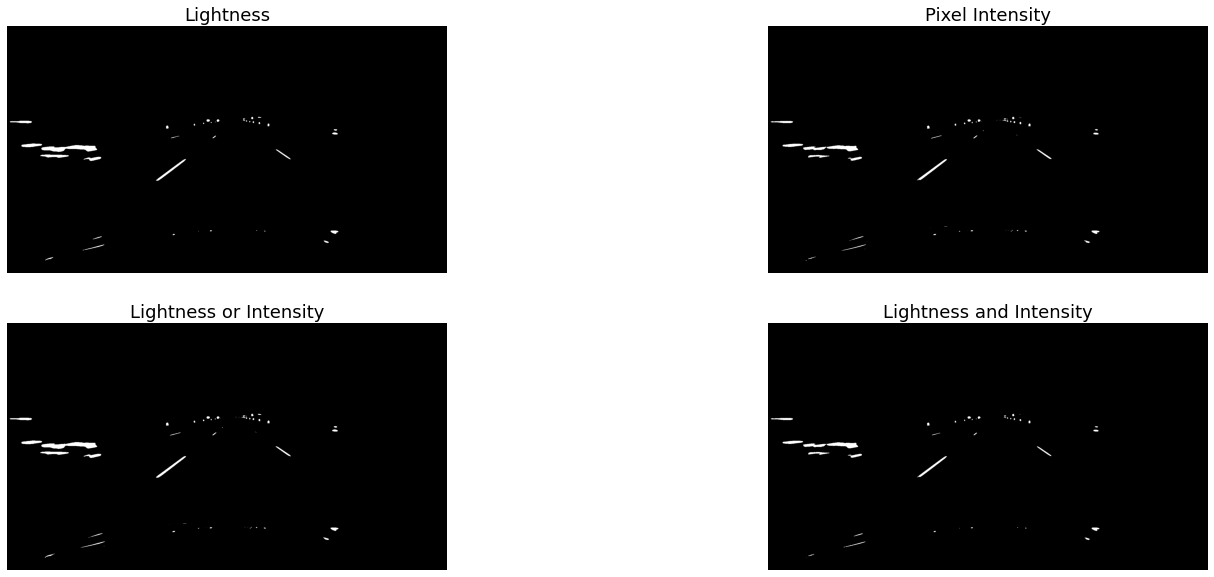

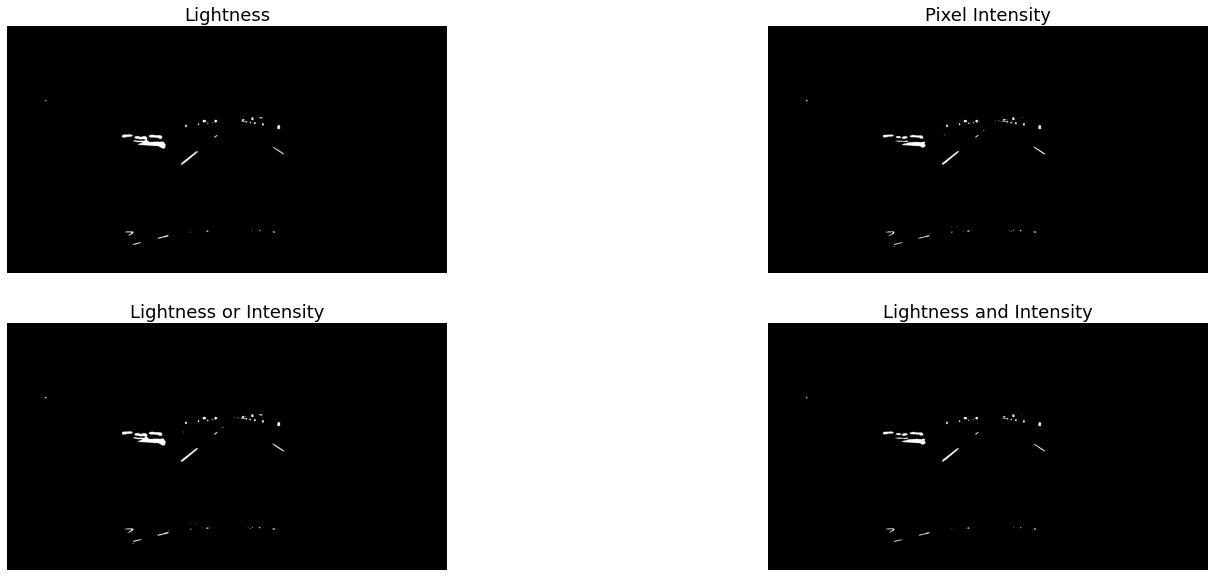

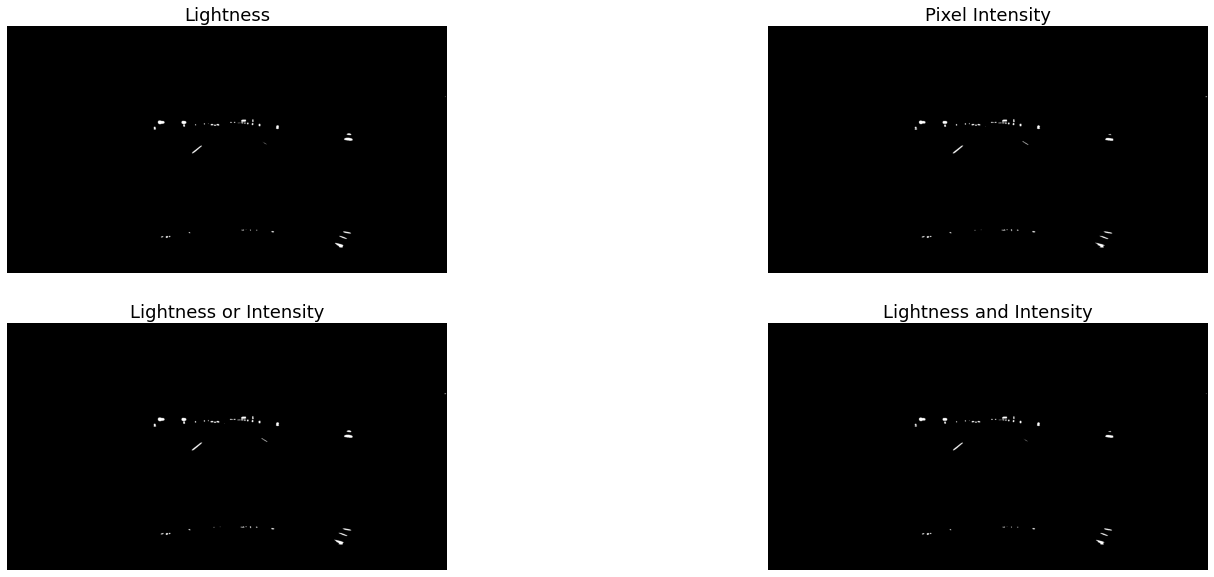

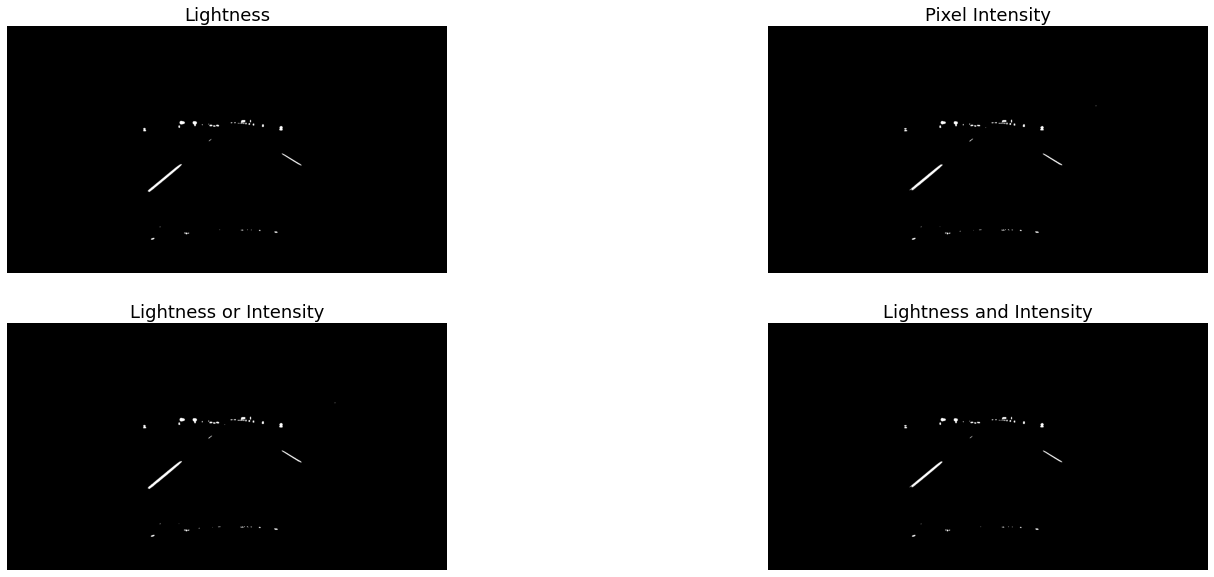

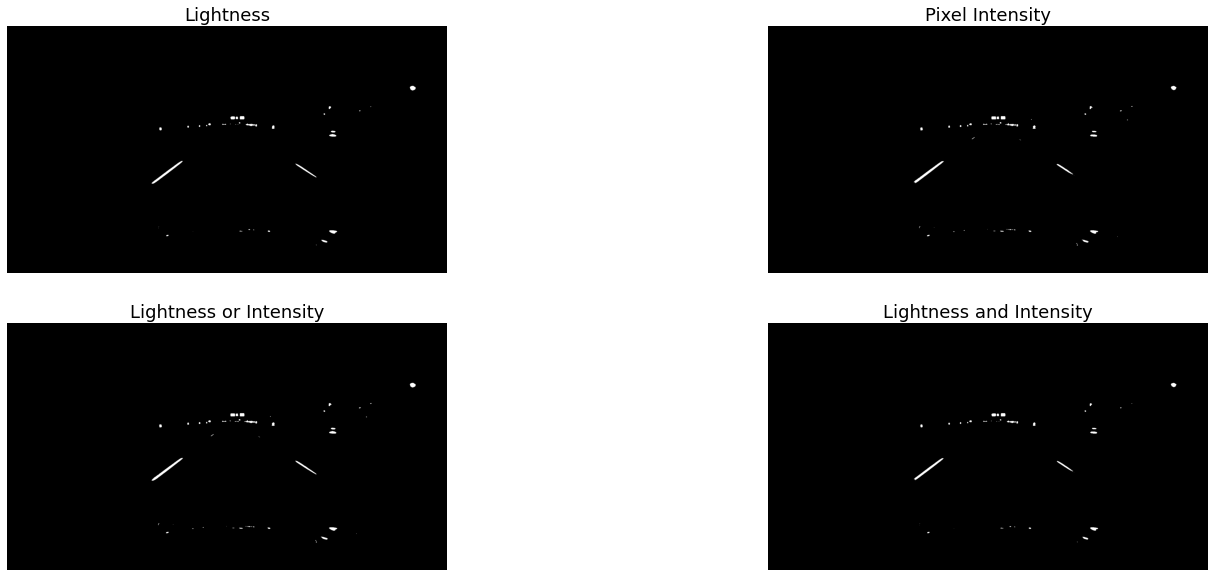

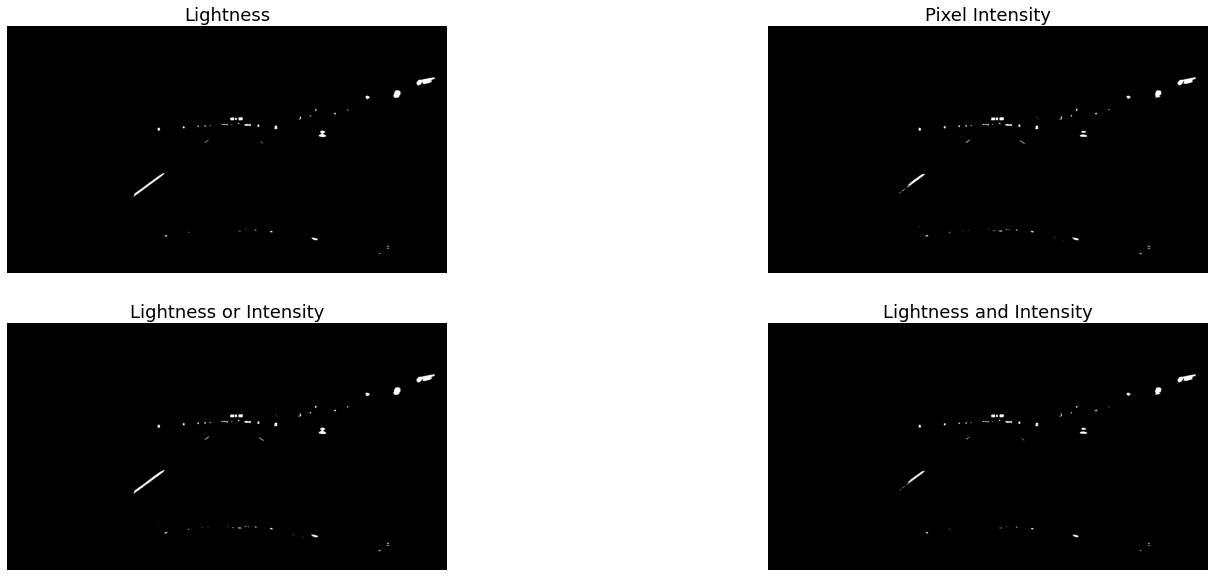

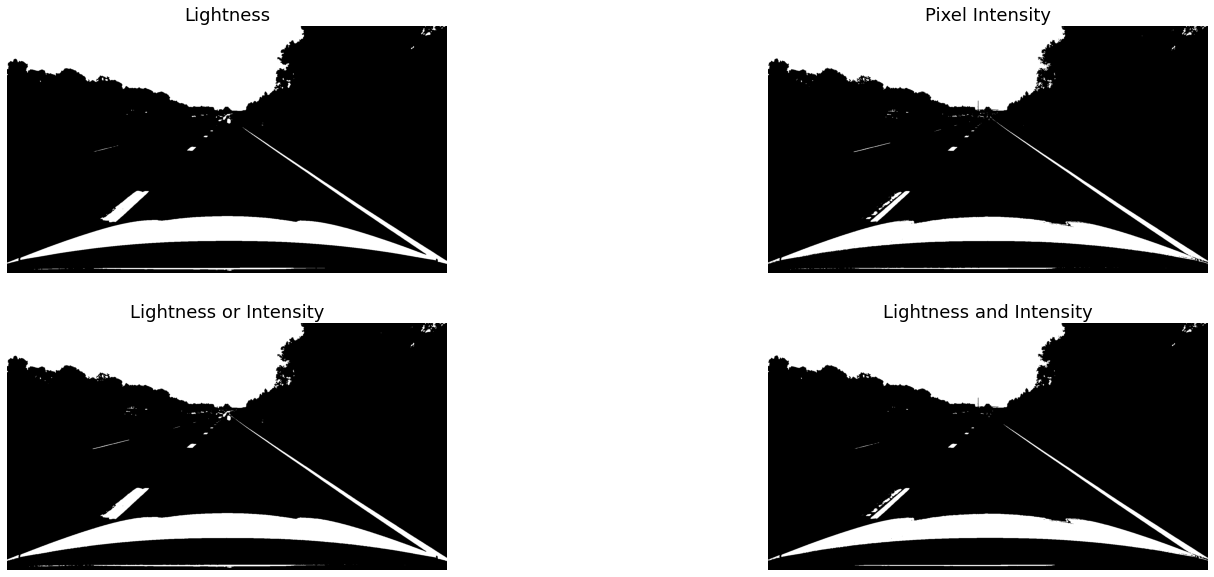

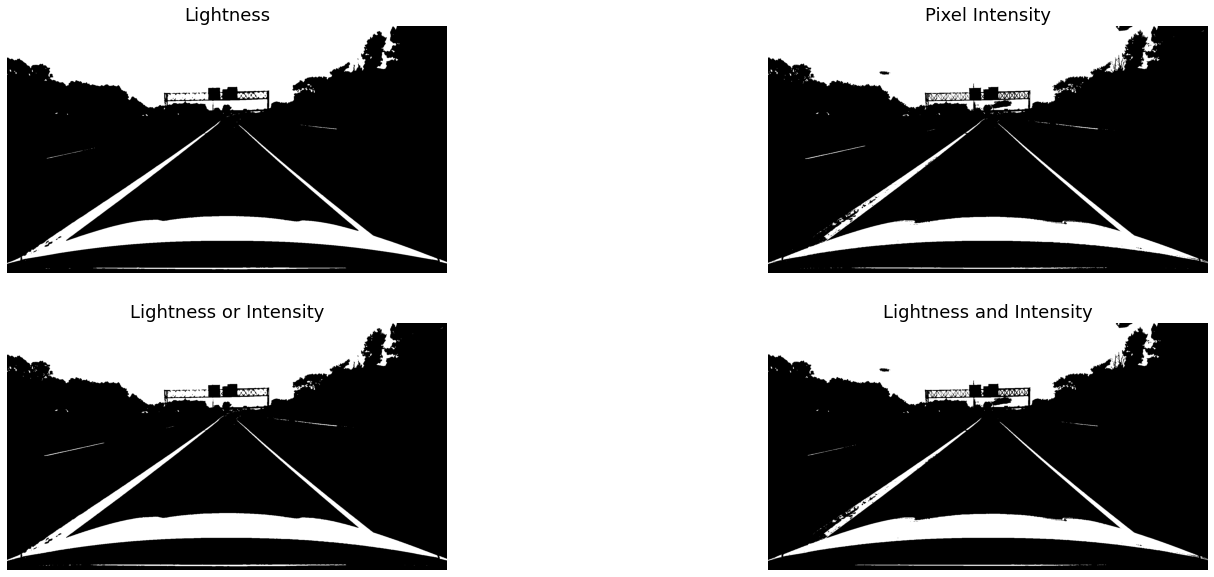

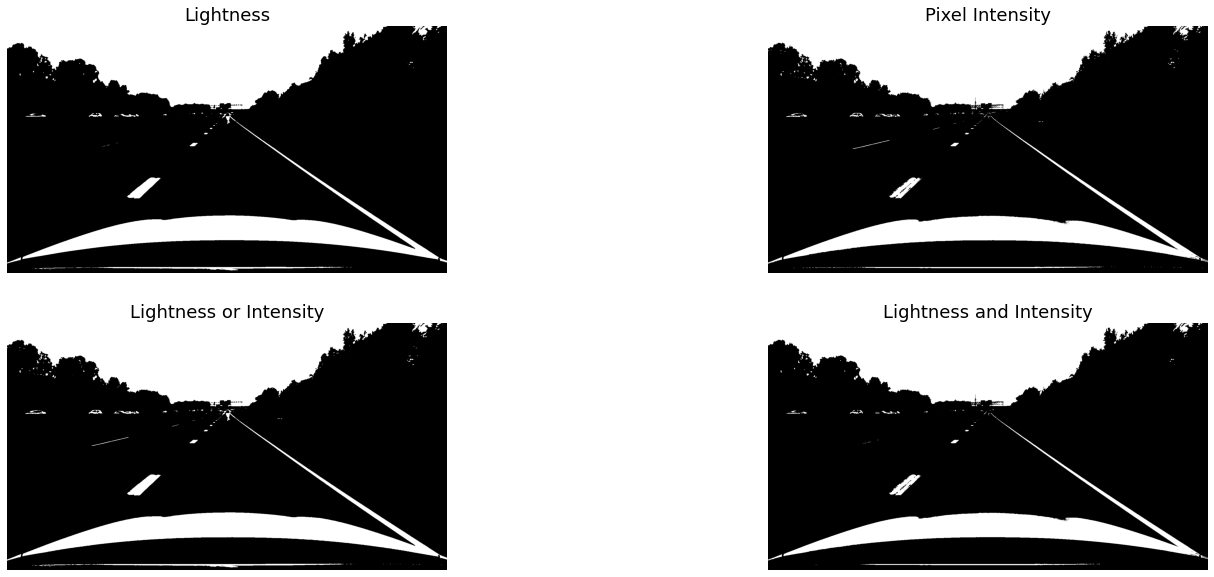

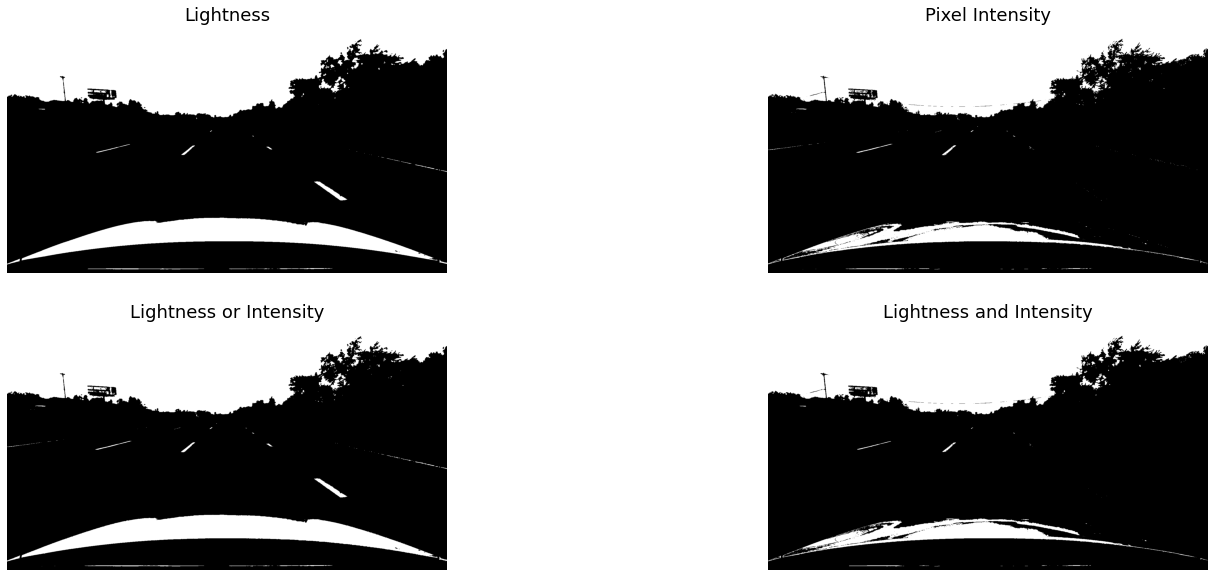

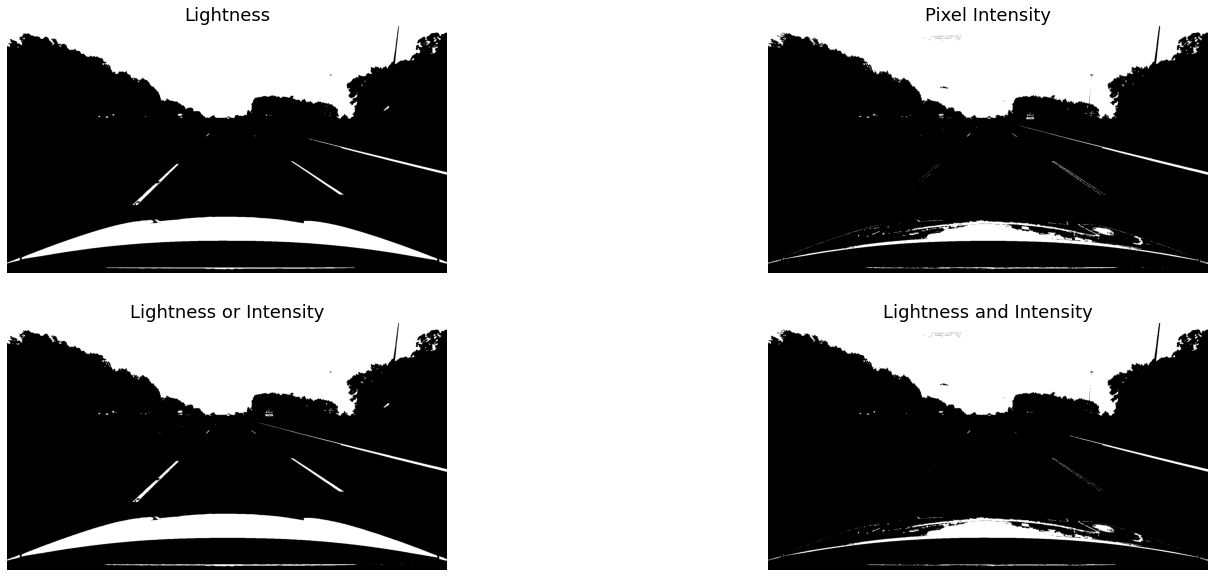

In [8]:
for i in directory:

    img = mpimg.imread(os.path.join("test_images/", i))

    # undistort the image
    undist = cv2.undistort(img, mtx, dst, None, mtx)
    mpimg.imsave(('test_images_output/undistorted/undistorted-'+i), undist, cmap = 'gray')
    
    # apply combined threshold and get the masked thresholded image
    thresholded_masked = combined_threshold(undist)
    # saving masked images
    mpimg.imsave(('test_images_output/thresholded_masked/masked-' + i), thresholded_masked, cmap = 'gray')

    binary_warped, M, Minv = perspective_view(thresholded_masked)
    mpimg.imsave(('test_images_output/binary_warped/binary_warped-'+i), binary_warped, cmap = 'gray')

#### Save mtx data for one image and plot the image

We will plot the masked region for better visualization. The following plot gives us details across different channels and thresholding levels for one image.

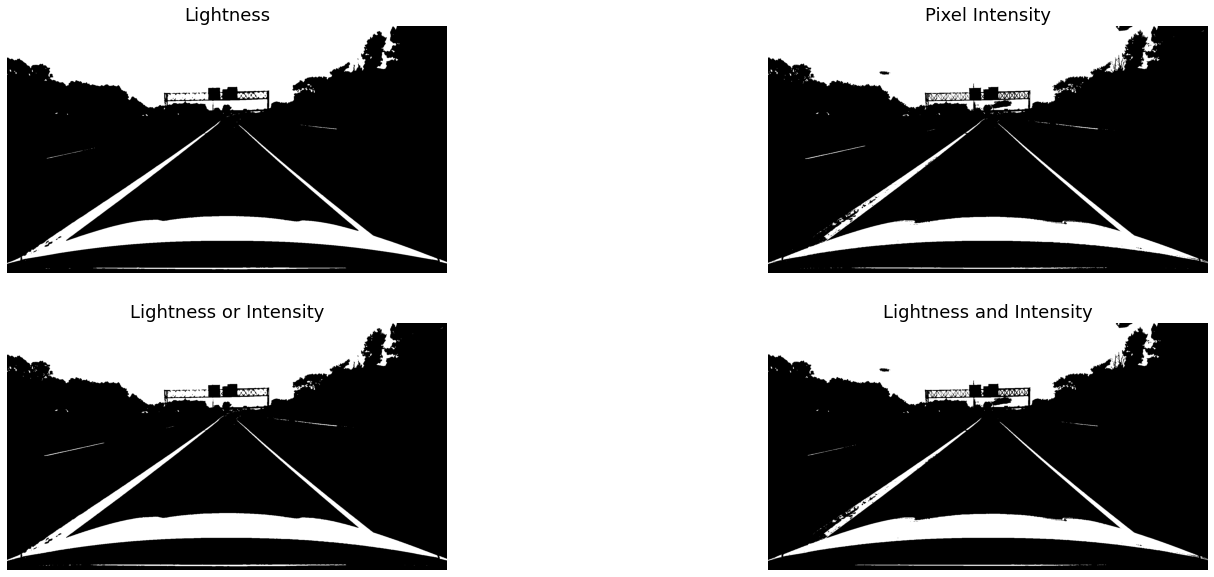

<Figure size 432x288 with 0 Axes>

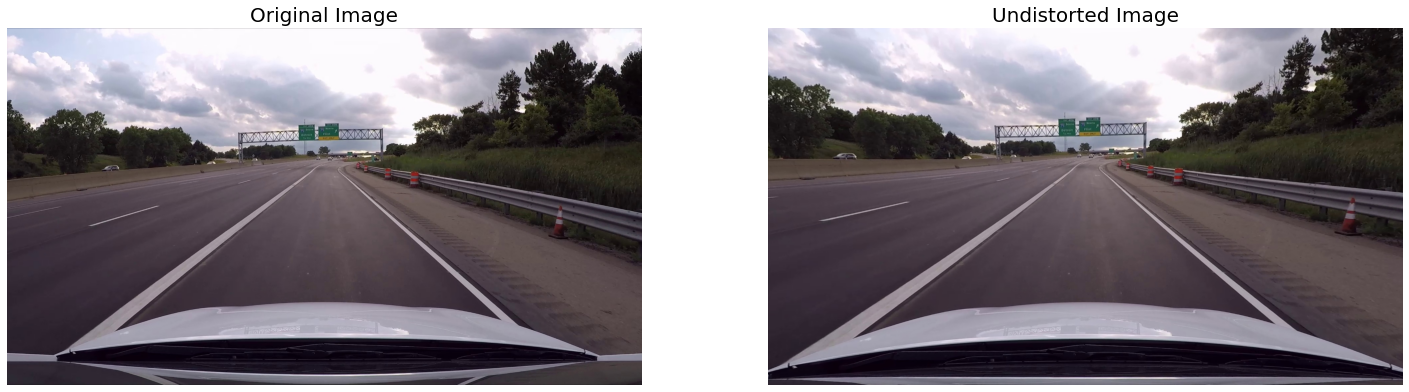

Following images show the original, threholded and warped images...


<Figure size 432x288 with 0 Axes>

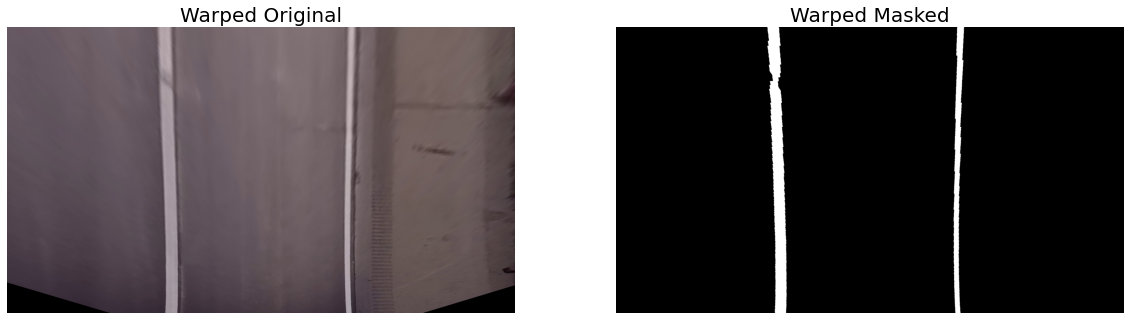

'\n# save new pickle for test images from car\'s camera\ndist_pickle = {}\ndist_pickle["mtx"] = mtx\ndist_pickle["dst"] = dst\ndist_pickle["M"] = M\ndist_pickle["Minv"] = Minv\npickle.dump(dist_pickle, open("pickle/test_images_dist_pickle.p", "wb"))\n\n'

In [9]:
# read in an image
img = mpimg.imread("test_images/test8.jpg")

# undistort the original image using stored values from pickle
undist_original = cv2.undistort(img, mtx, dst, None, mtx)

# apply perspective view on the image
warped_original, M, Minv = perspective_view(undist_original)

# apply combined threshold
combined_threshold_img = combined_threshold(undist_original)

# apply perspective transform on the thresholded image
warped, M, Minv = perspective_view(combined_threshold_img)

plt.figure(2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax1.axis('off')
ax2.imshow(undist_original)
ax2.set_title('Undistorted Image', fontsize=20)
ax2.axis('off')
plt.show()

print("Following images show the original, threholded and warped images...")

plt.figure(3)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(warped_original)
ax3.set_title('Warped Original', fontsize=20)
ax3.axis('off')
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Masked', fontsize=20)
ax4.axis('off')
plt.show()


# this is necessary only if images are taken using a different camera
# than the one used for chessboard corners

'''
# save new pickle for test images from car's camera
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dst"] = dst
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump(dist_pickle, open("pickle/test_images_dist_pickle.p", "wb"))

'''

### Finding Lane Pixels
#### Lane Finding Method: Peaks in a histogram

After applying calibration, thresholding, and a perspective transform to a road image, we have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

We define this using the hist function from NumPy. With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We should get a output that looks as shown below.

From here, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame. We use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go. Here is how it is done -


(1080, 1920, 3)


"\nplt.figure(5)\nf, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))\nax1.plot(histogram)\nax1.set_title('Plotted Histogram', fontsize=18)\nax2.imshow(img)\nax2.set_title('Binary Warped Image', fontsize=18)\n\n"

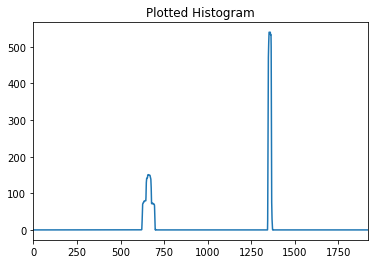

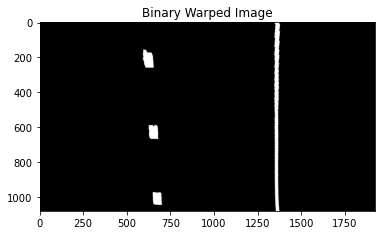

In [10]:
# first we will demo the histogram function
img = mpimg.imread('test_images_output/binary_warped/binary_warped-test9.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Create histogram of image binary activations

histogram = hist(img[:,:,1])
print(img.shape)


# Visualize the resulting histogram
plt.figure(3)
plt.plot(histogram)
plt.title('Plotted Histogram')
plt.xlim(0, 1920)

plt.figure(4)
plt.imshow(img)
plt.title('Binary Warped Image')
plt.xlim(0, 1920)

'''
plt.figure(5)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax1.plot(histogram)
ax1.set_title('Plotted Histogram', fontsize=18)
ax2.imshow(img)
ax2.set_title('Binary Warped Image', fontsize=18)

'''


## PIPELINE

### (for detecting lanelines and calculating road curvature)

Here, we will establish a pipeline for detecting lanelines. We have created a class in a separate file *class_lanelines.py* which stores lanelines as objects along with their properties such as left and right fits.

![image](readme_images/color-fit-lines.jpg)

---
1. We use the approach of sliding boxes from bottom to top in our histogram to detect laneline pixels and get their co-ordinates.
2. Once we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. We store the x and y co-ordinates of these pixels in lists leftx, lefty, rightx and righty.
3. After fitting a 2nd order polynomial using the NumPy function [np.polyfit()](https://numpy.org/doc/1.18/reference/generated/numpy.polyfit.html), we plot the lines using a linspace model on our image.
4. Then, we calculate the radius of curvature using the following mathematical equations. The following formula gives us road curvature radius in pixels.

![image](readme_images/formulae.png)

5. We convert the road curvature from pixels to meters.

### Lanelines Function

This function contains code for detecting lanelines bases on our approach as explained above. Later on, this function will be used repeatedly for detecting lanelines in our video stream.

I have also included functionality here to store previous lanelines data (2nd order equations) so that they can be used for successive frames. The variables ***avg_left_fit*** and ***avg_right_it*** are calculated based on the measurements of previous 12 frames. This helps the code to fit lanelines for the current frame even if they are not detected.

For a vehicle traveling at maximum speed of 80mph (as per legal limits on most roads in US), the vehicle travels about 35 m/sec. The camera records the video stream at 30 frames/second. Hence, for our weighted averaging of 12 frames/second, the vehicle moves just about 14m (about 3 car lengths) and can be approximated. It can be safely assumed that lanelines will not change significantly during such a smaller distance. This value will be even smaller for lower speeds. Hence, it is safe for approximation.

In [11]:
def advanced_lanelines(img):

    # undistort the original image using stored values from pickle
    undist_original = cv2.undistort(img, mtx, dst, None, mtx)
    # apply perspective view on the image
    warped_original, M, Minv = perspective_view(undist_original)

    # apply combined threshold
    threshold = combined_threshold(img)
    # undistort the thresholded image
    undist_thresholded = cv2.undistort(threshold, mtx, dst, None, mtx)
    # apply perspective transform on the thresholded image
    warped, M, Minv = perspective_view(undist_thresholded)

    # these will be empty for the first iteration and they will store the values of lane fits from previous iterations
    # declaring lane fits as global variables so that they can be modified from anywhere in the code
    
    # list storing left and right lanefit values from previous frames
    global previous_left_fit
    global previous_right_fit
    
    global prev_left_fits
    global prev_right_fits

    # average of previous 10 lanefits
    global average_left_fit
    global average_right_fit

    global past_radii


    # initialize the lanelines class by giving inputs from previous iteration
    binary_warped = LaneLines(warped, average_left_fit, average_right_fit, previous_left_fit, previous_right_fit)

    # calculate the left and right lane fits
    out_img, leftfit, rightfit = binary_warped.find_lane_pixels()

    # we convert our left and right fits from shape (3,) to an array of shape (1,3) to append it to our lists
    previous_left_fit_array = np.array([leftfit])
    previous_right_fit_array = np.array([rightfit])

    # print("frame = ", frame)
    # print("left fit = ", leftfit)
    # print("right fit = ", rightfit)

    # we add fits from previous detections to our list of previous fits
    prev_left_fits = np.append(prev_left_fits, previous_left_fit_array, axis = 0)
    prev_right_fits = np.append(prev_right_fits, previous_right_fit_array, axis = 0)

    # we ensure that the list doesn't take into account more than 15 previous measurements
    # we delete the initial element of the array if it does, i.e. - earliest element in the array
    if (prev_left_fits.shape[0] > 10):
        prev_left_fits = np.delete(prev_left_fits, 0, axis = 0)
    if(prev_right_fits.shape[0] > 10):
        prev_right_fits = np.delete(prev_right_fits, 0, axis = 0)

    # compute average of past 10 best fits and pass them over to next iteration
    average_left_fit = np.mean(prev_left_fits, axis = 0)
    average_right_fit = np.mean(prev_right_fits, axis = 0)

    # print("Average Left Fit = ", average_left_fit)
    # print("Average Right Fit = ", average_right_fit)

    # get the left and right lane radii
    center_offset, left_radius, right_radius = binary_warped.measure_curvature()

    # START OF RADIUS CALCULATIONS
    # calculation of road curvature
    current_road_radius = 0.5*(left_radius+right_radius)

    # Storing past five frame's radii 
    past_radii.append(current_road_radius)
    # calculate weighted average of radii to reduce noisy measurements
    road_radius = sum(past_radii)/len(past_radii)

    # if no outliers are detected then, delete the oldest value
    if (len(past_radii) > 5):
        past_radii.pop(0)

    # calculate mean radius
    road_radius = sum(past_radii)/len(past_radii)
    road_radius = round(road_radius)

    center_offset = round(center_offset, 2)
    road_curvature = "Road Curvature = " + str(road_radius) + "m"
    center_offset = "Center Offset = " + str(center_offset) + "m"

    # print("Left = ", left_radius)
    # print("Right = ", right_radius)
    # print("Road Curvature = ", road_radius)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([binary_warped.left_fitx, binary_warped.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([binary_warped.right_fitx, binary_warped.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist_original, 1, unwarped, 0.3, 0)

    # this prints the value of road curvature onto the output image
    cv2.putText(result, road_curvature, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), thickness=2)

    # this prints the value of center offset onto the output image
    cv2.putText(result, center_offset, (25, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), thickness=2)

    # overlay images
    img2_resize = cv2.resize(out_img, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_CUBIC)
    result[15:15+img2_resize.shape[0],1521:1521+img2_resize.shape[1]] = img2_resize


    # VISUALIZATION
    # THIS SECTION SHOULD BE COMMENTED OUT WHEN RUNNING ON VIDEO STREAM
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax1.axis('off')
    ax2.imshow(threshold, cmap = 'gray')
    ax2.set_title('Original Thresholded', fontsize=20)
    ax2.axis('off')
    ax3.imshow(warped_original, cmap = 'gray')
    ax3.set_title('Warped Perspective', fontsize=20)
    ax3.axis('off')
    ax4.imshow(out_img)
    ax4.set_title('Sliding Boxes', fontsize=20)
    ax4.axis('off')
    plt.show()
    

    previous_left_fit = leftfit
    previous_right_fit = rightfit

    return result

#### Testing our pipeline on a couple of images

Here, we will call our function ***advanced_lanelines*** and execute it on a test image and display the results.

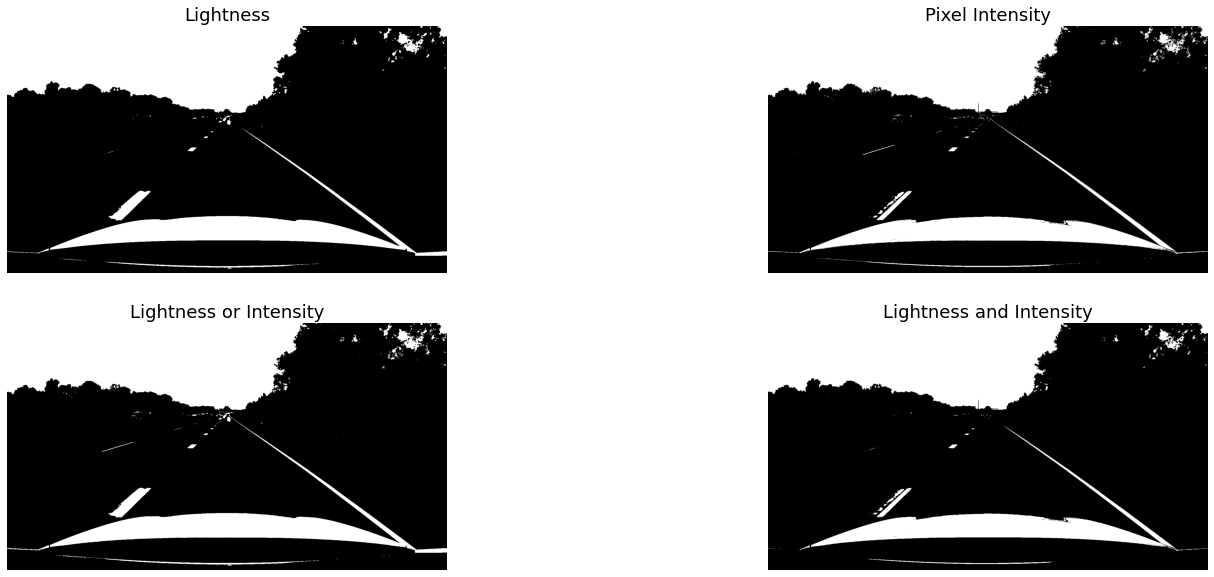

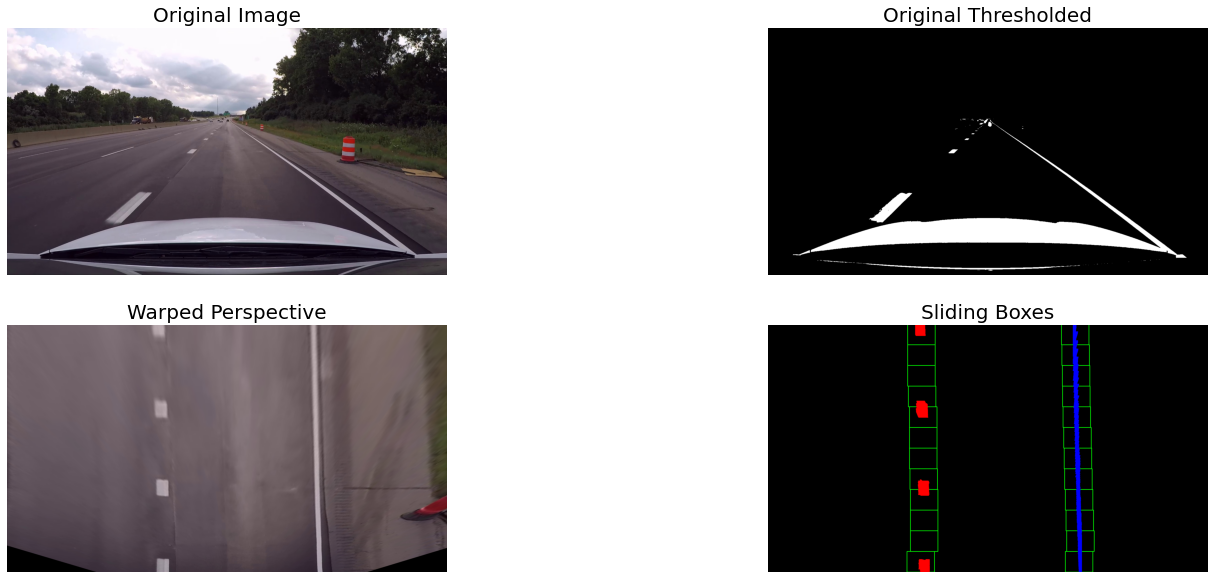

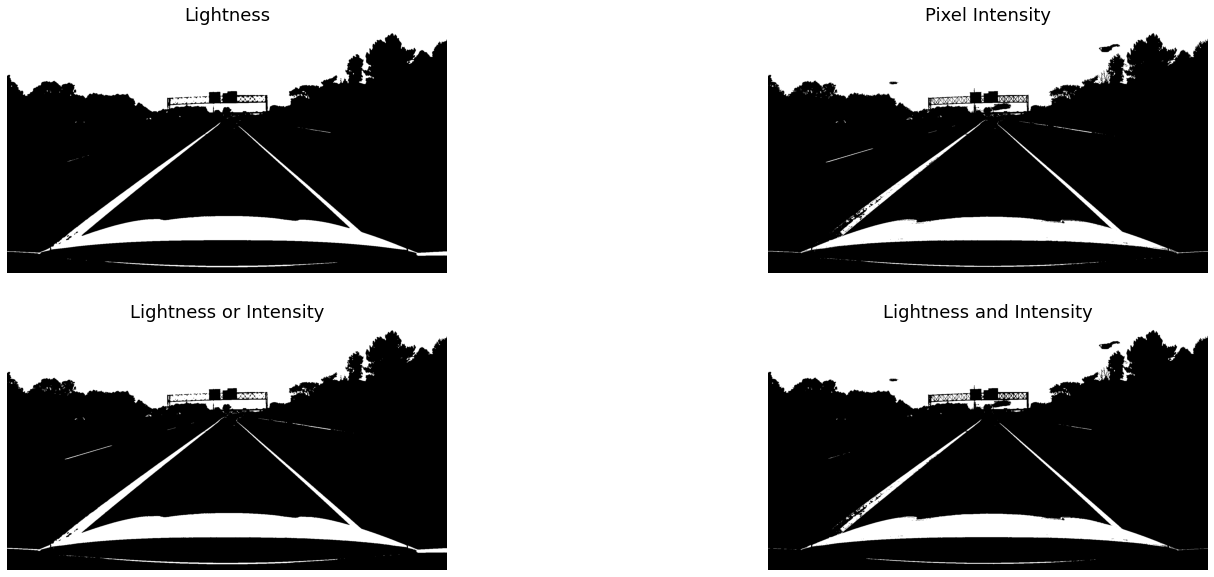

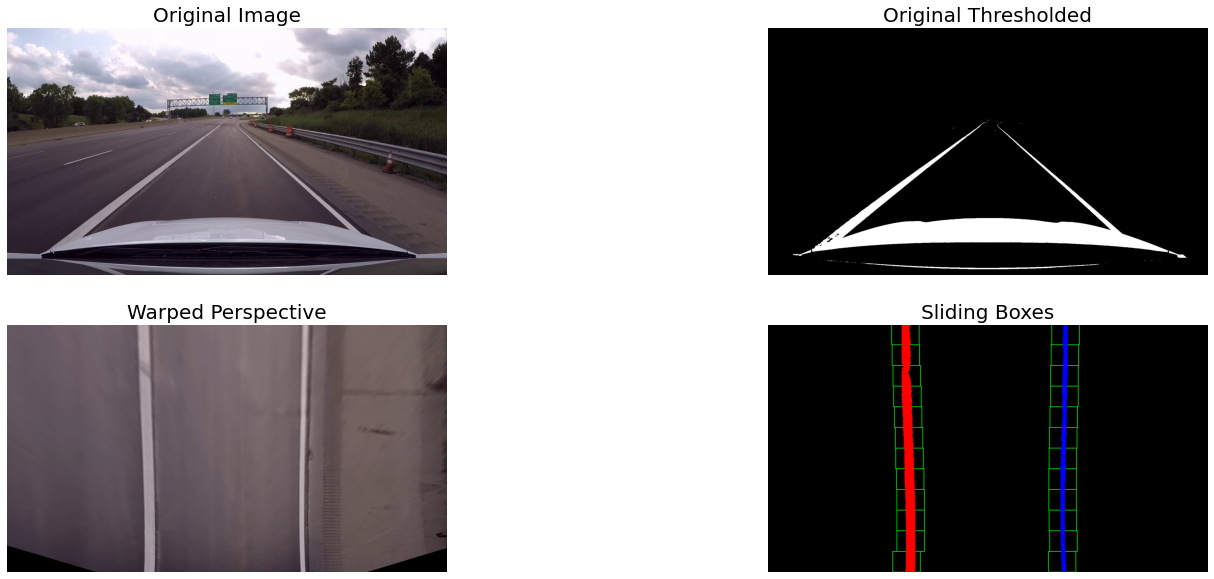

In [12]:

# define variables needed in the global scope
# these variables store the left and right fits from the previous frame
previous_left_fit = None
previous_right_fit = None

# these variables store the average left and right fits for past 10 frames
previous_avg_left_fit = None
previous_avg_right_fit = None

# initialize empty 1*3 empty arrays for storing lane fit data of previous 10 frames
prev_left_fits = np.empty([1,3])
prev_right_fits = np.empty([1,3])

# initialize list for storing past radius measurements
past_radii = [0, 0, 0, 0, 0]

# intitialize the average left and right fit empty lists - these will be updated in every iteration
average_left_fit = []
average_right_fit = []

# import the lanelines class
from class_lanelines_1 import LaneLines

# image pipeline - run for two successive images"
test_image = mpimg.imread("test_images/test7.jpg")
lane_image = advanced_lanelines(test_image)

test_image2 = mpimg.imread("test_images/test8.jpg")
lane_image2 = advanced_lanelines(test_image2)

### Display Result

Final resulting image showing lane markings and road curvature values

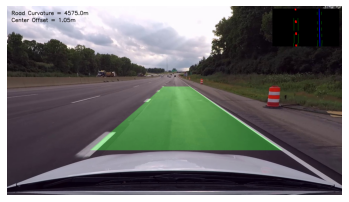

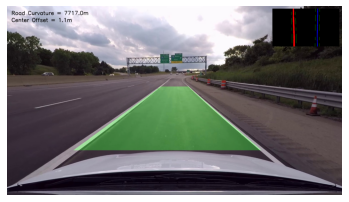

In [13]:
mpimg.imsave('readme_images/detected_lane_image.jpg', lane_image)
plt.imshow(lane_image)
plt.axis('off')
plt.show()

plt.imshow(lane_image2)
plt.axis('off')
plt.show()